In [1]:
import pandas as pd 
import numpy as np
select_blackbox = ['dt', 'nn', 'rf'][1]

df = pd.read_csv("data/output/result.csv", header=None)
df.columns = ['accuracy', 'blackbox', 'dataset', 'explainer', 'explanation', 'explanation size', 'positive counterexamples', 'query', 'random words checked', 'terminate', 'time', 'time learner', 'time verifier', 'total counterexamples']
df = df[df['blackbox'] == select_blackbox]
print("minimum iterations:", min(df.groupby(['query'])['explanation'].count()), "max iterations:",max(df.groupby(['query'])['explanation'].count()))
df.head()

minimum iterations: 147 max iterations: 259


,accuracy,blackbox,dataset,explainer,explanation,explanation size,positive counterexamples,query,random words checked,terminate,time,time learner,time verifier,total counterexamples
0,0.066667,nn,iris,sygus,(and (> sepal-length (/ 1 4)) (and (> petal-l...,4.0,0.500000,- threshold: 0.1\n- specific_input: [0.3888888...,37.0,0.0,301.104896,297.428000,2.672167,10.0
1,0.200000,nn,iris,sygus,(let ((_let_0 (> sepal-length (/ 1 4)))) (or ...,8.0,0.500000,- threshold: 0.1\n- specific_input: [0.3888888...,92.0,0.0,301.026062,292.770658,7.244663,24.0
2,0.272727,nn,zoo,sygus,(and hair (and milk backbone)),3.0,0.050000,"- threshold: 0.1\n- specific_input: [1.0, 0.0,...",3708.0,0.0,301.059186,60.055904,239.994294,20.0
3,0.200000,nn,iris,sygus,(or (and (> petal-length (/ 3 4)) (< petal-wi...,8.0,0.500000,- threshold: 0.1\n- specific_input: [0.3888888...,72.0,0.0,301.022952,294.342031,5.671324,22.0
4,0.266667,nn,iris,sygus,(or (and (> sepal-length (/ 1 4)) (> petal-le...,7.0,0.518519,- threshold: 0.1\n- specific_input: [0.3888888...,107.0,0.0,301.018365,291.117072,8.889614,27.0


In [3]:
# take median
group_list = ['dataset','explainer','query']
df_med = df.groupby(group_list).median()
df_med.reset_index(inplace=True)
df_med

,dataset,explainer,query,accuracy,explanation size,positive counterexamples,random words checked,terminate,time,time learner,time verifier,total counterexamples
0,adult,sygus,"- threshold: 0.1\n- specific_input: [1.0, 0.24...",0.204299,3.0,0.090909,5403.0,0.0,311.348107,10.653473,299.053131,31.0
1,iris,sygus,- threshold: 0.1\n- specific_input: [0.3888888...,0.466667,8.0,0.384615,74.0,0.0,301.104268,281.085516,18.961250,15.0
2,zoo,sygus,"- threshold: 0.1\n- specific_input: [1.0, 0.0,...",0.727273,3.0,0.076923,1293.0,0.0,331.861343,10.102916,315.780045,15.0


In [6]:
# find representative explanation
query_explanations = {}
for key, item in df.groupby(['dataset','explainer','query'], as_index = False):
    item.reset_index(inplace=True, drop=True)
    if(len(item) == 1):
        query_explanations[key] = item['explanation'].item()
    else:
        # nearest explanation to the average accuracy
        explanation = item.iloc[item.index[(item['accuracy']-df_med['accuracy'][(df_med['dataset'] == key[0]) & (df_med['explainer'] == key[1]) & (df_med['query'] == key[2])].item()).abs().argsort()][0]]['explanation']
        query_explanations[key] = explanation

In [4]:
df_output = df_med
df_output = df_output.drop("terminate", axis=1)
df_output['explanation'] = np.nan 
for key in query_explanations:
    df_output['explanation'][(df_output['dataset'] == key[0]) & (df_output['explainer'] == key[1]) & (df_output['query'] == key[2])] = query_explanations[key]

# reorganise columns
df_output = df_output[[ 'explainer','query', 'explanation', 'accuracy', 'time', 'time learner', 'time verifier', 'random words checked', 'total counterexamples', 'positive counterexamples']]
df_output = df_output.round(2)
df_output.head()

,explainer,query,explanation,accuracy,time,time learner,time verifier,random words checked,total counterexamples,positive counterexamples
0,decision tree,"- threshold: 0.1\n- specific_input: [1.0, 0.24...",data/output/dt/2020-09-14 11:41:24.585102.pkl,0.49,1.83,0.11,1.71,1094.0,9.0,0.11
1,logistic regression,"- threshold: 0.1\n- specific_input: [1.0, 0.24...",[ 0.26855579 0.05212906 0.11615495 -0.269546...,0.54,0.49,0.20,0.29,191.0,3.0,0.33
2,sygus,"- threshold: 0.1\n- specific_input: [1.0, 0.24...",(and sex (and (not race_0) (not race_3))),0.79,33.58,3.62,28.95,1733.0,13.0,0.08


### Query

- threshold: 0.1
- specific_input: [1.0, 0.2465753424657534, 0.5333333333333333, 0.0, 0.0, 0.39795918367346933, 0.0, 0.0, 0.0, 0.0, 1.0]
- detailed_input: [('sex', 1.0), ('age', 0.2465753424657534), ('education-num', 0.5333333333333333), ('capital-gain', 0.0), ('capital-loss', 0.0), ('hours-per-week', 0.39795918367346933), ('race_0', 0.0), ('race_1', 0.0), ('race_2', 0.0), ('race_3', 0.0), ('race_4', 1.0)]


### Result for decision tree

def tree(hair, feathers, eggs, milk, airborne, aquatic, predator, toothed, backbone, breathes, venomous, fins, legs, tail, domestic, catsize):

    if airborne <= 0.0005000000237487257:
        if breathes <= 0.5:
            return 1
        else:
            return 0
    else:
        return 0



accuracy 0.49





### Query

- threshold: 0.1
- specific_input: [1.0, 0.2465753424657534, 0.5333333333333333, 0.0, 0.0, 0.39795918367346933, 0.0, 0.0, 0.0, 0.0, 1.0]
- detailed_input: [('sex', 1.0), ('age', 0.2465753424657534), ('education-num', 0.5333333333333333), ('capital-gain', 0.0), ('capital-loss', 0.0), ('hours-per-week', 0.39795918367346933), ('race_0', 0.0), ('race_1', 0.0), ('race_2', 0.0), ('race_3', 0.0), ('race_4', 1.0)]


### Result for logistic regression

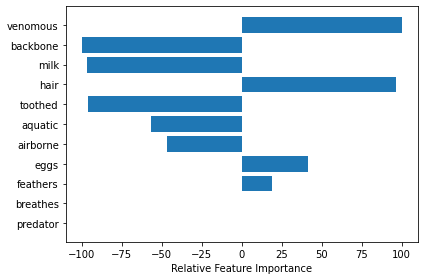



accuracy 0.54





### Query

- threshold: 0.1
- specific_input: [1.0, 0.2465753424657534, 0.5333333333333333, 0.0, 0.0, 0.39795918367346933, 0.0, 0.0, 0.0, 0.0, 1.0]
- detailed_input: [('sex', 1.0), ('age', 0.2465753424657534), ('education-num', 0.5333333333333333), ('capital-gain', 0.0), ('capital-loss', 0.0), ('hours-per-week', 0.39795918367346933), ('race_0', 0.0), ('race_1', 0.0), ('race_2', 0.0), ('race_3', 0.0), ('race_4', 1.0)]


### Result for sygus

(and sex (and (not race_0) (not race_3)))


accuracy 0.79


In [5]:
import matplotlib.pyplot as plt
import pickle
from IPython.display import Markdown, display
from trustable_explanation import helper_functions
import numpy as np


features = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']
# print results in an explainable manner
for key, item in df_output.groupby(['query','explainer'], as_index = False):
    print("\n\n")
    display(Markdown("### Query"))
    print(key[0])
    display(Markdown("### Result for " + key[1]))
    if(key[1] == "logistic regression"):
        feature_importance = np.fromstring(item['explanation'].item()[1:-1], dtype=np.float, sep=' ')
        feature_importance = 100.0 * (feature_importance / (abs(feature_importance).max()))
        sorted_idx = np.argsort(abs(feature_importance))
        pos = np.arange(sorted_idx.shape[0]) + .5
        featfig = plt.figure()
        featax = featfig.add_subplot(1, 1, 1)
        featax.barh(pos, feature_importance[sorted_idx], align='center')
        featax.set_yticks(pos)
        featax.set_yticklabels(np.array(features)[sorted_idx])
        featax.set_xlabel('Relative Feature Importance')
        plt.tight_layout()   
        plt.show()
    elif(key[1] == "decision tree"):
        dt = None
        with open(item['explanation'].item(), 'rb') as fid:
            dt = pickle.load(fid)
        print(helper_functions.tree_to_code(dt,features))
    else:
        print(item['explanation'].item())
    print("\n\naccuracy",item['accuracy'].item())


In [70]:
# to remote 
# df_output.to_csv("data/output/summary.csv", index = False)
df_output.to_csv("/home/bishwamittra/Dropbox/trustable_explanations/result.csv", index = False)